In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import skimage.io
import random

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
IMG_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'

# Load and orgenize the data

In [138]:
"""read csv to numpy arrays"""
dfTrain = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_train.csv'))
dfTest = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_test.csv'))

X_train = dfTrain.as_matrix(columns=dfTrain.columns[1:]).astype(np.uint8)
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_test = dfTest.as_matrix(columns=dfTrain.columns[1:])
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Data Exploration

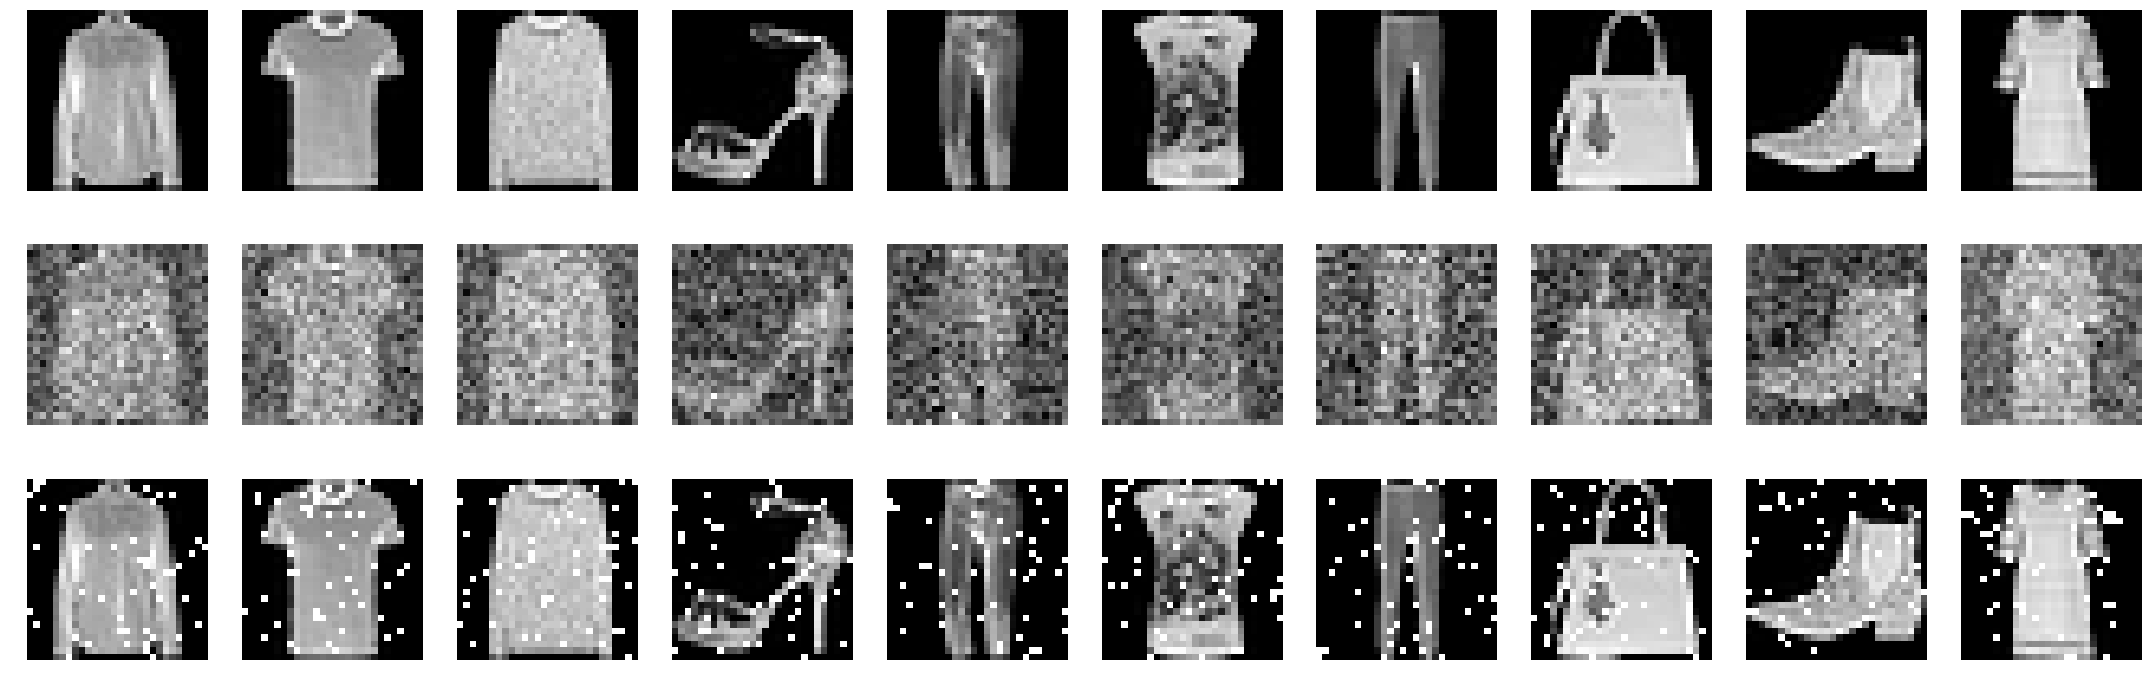

In [160]:
def saltAndPepperNoise(cleanImgs, k=50):        
    noisyImgs = np.zeros(cleanImgs.shape, cleanImgs.dtype)
    for i in range (len(cleanImgs)):
        randomFlat = np.random.randint(0, IMG_WIDTH*IMG_HEIGHT-1, size=k)
        noiseCoor = np.unravel_index(randomFlat, dims=(IMG_WIDTH, IMG_HEIGHT))
        noiseBG = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.float32)
        noiseBG[noiseCoor[0][:],noiseCoor[1][:]] = 1.0
        noiseImg = np.clip(np.add(noiseBG, cleanImgs[i]), 0.0, 1.0)
        noisyImgs[i] = noiseImg
    return noisyImgs

# add addtive Gaussian noise to original images
noiseFactor = 0.3
X_trainNoiseGauss = X_train + noiseFactor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_testNoiseGauss = X_test + noiseFactor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
# add salt and pepper noise to original images
X_testNoiseSnP = saltAndPepperNoise(X_test)
X_trainNoiseSnP = saltAndPepperNoise(X_train)

# plot original images and noisy images
fig, axes = plt.subplots(3, numOfFigs, figsize=(30, 10))
for i in range(0, numOfFigs):
    index = random.randint(0, X_train.shape[0])    
    axes[0][i].imshow(X_train[index,:, :, 0], cmap='gray')
    axes[1][i].imshow(X_trainNoiseGauss[index,:,:,0], cmap='gray')    
    axes[2][i].imshow(X_trainNoiseSnP[index,:, :, 0], cmap='gray')
    axes[0][i].axis('off') 
    axes[1][i].axis('off') 
    axes[2][i].axis('off') 
    
plt.tight_layout()
plt.show()


# Auto-Encoder Model

In [28]:
inputImg = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Encoding part
conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputImg)
pool1 = MaxPooling2D((2,2), padding='same')(conv1)
conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2,2), padding='same')(conv2)
conv3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2,2), padding='same')(conv3)

# Decoding part
conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(pool3)
up4 = UpSampling2D()(conv4)
conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(up4)
up5 = UpSampling2D()(conv5)
conv6 = Conv2D(16, (3,3), activation='relu')(up5)
up6 = UpSampling2D()(conv6)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up6)

ae = Model(inputImg, out)
ae.compile(optimizer='adam', loss='binary_crossentropy')
ae.summary()
print('latent space dimensions are 4x4x64 = 1024')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 64)          0         
__________

# Training Phase

In [169]:
X_trainAllNoises = np.concatenate((X_trainNoiseGauss, X_trainNoiseSnP), axis=0)
X_testAllNoises = np.concatenate((X_testNoiseGauss, X_testNoiseSnP), axis=0)

ae.fit(X_trainAllNoises, np.concatenate((X_train, X_train), axis=0), epochs=20, batch_size=32, 
       validation_data=(X_testAllNoises, np.concatenate((X_test, X_test), axis=0)))

Train on 120000 samples, validate on 20000 samples
Epoch 1/20
120000/120000 [==============================] - 330s 3ms/step - loss: 0.2687 - val_loss: 0.2667
Epoch 2/20
120000/120000 [==============================] - 468s 4ms/step - loss: 0.2680 - val_loss: 0.2669
Epoch 3/20
120000/120000 [==============================] - 438s 4ms/step - loss: 0.2676 - val_loss: 0.2664
Epoch 4/20
120000/120000 [==============================] - 454s 4ms/step - loss: 0.2673 - val_loss: 0.2660
Epoch 5/20
120000/120000 [==============================] - 453s 4ms/step - loss: 0.2671 - val_loss: 0.2660
Epoch 6/20
120000/120000 [==============================] - 459s 4ms/step - loss: 0.2670 - val_loss: 0.2659
Epoch 7/20
120000/120000 [==============================] - 457s 4ms/step - loss: 0.2668 - val_loss: 0.2657
Epoch 8/20
120000/120000 [==============================] - 304s 3ms/step - loss: 0.2667 - val_loss: 0.2654
Epoch 9/20
120000/120000 [==============================] - 458s 4ms/step - loss: 0.2

In [171]:
encoder = Model(inputImg, pool3)
encodedImgs = encoder.predict(X_testAllNoises)
DenoisedImgs = ae.predict(X_testAllNoises)

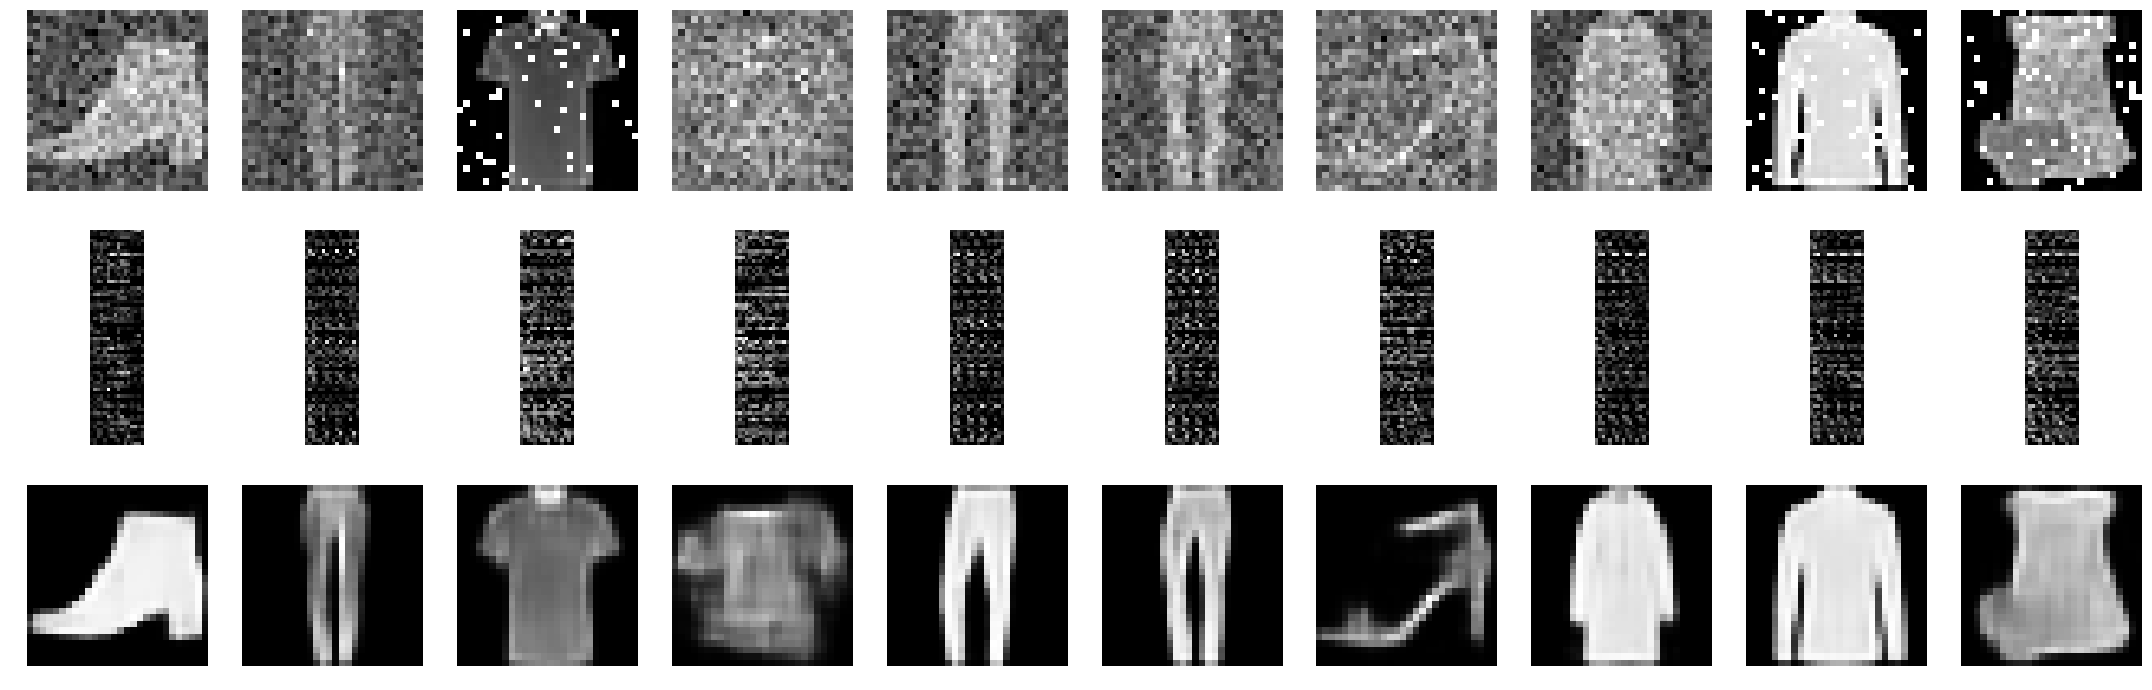

In [172]:
numOfFigs = 10
encodedImgs = encodedImgs.reshape((-1, 16, 64))
fig, axes = plt.subplots(3, numOfFigs, figsize=(30, 10))
for i in range(0, numOfFigs):
    index = random.randint(0, X_testAllNoises.shape[0])    
    axes[0][i].imshow(X_testAllNoises[index,:, :, 0], cmap='gray')
    axes[1][i].imshow((encodedImgs[index]).transpose() [:, :], cmap='gray')    
    axes[2][i].imshow(DenoisedImgs[index,:, :, 0], cmap='gray')
    axes[0][i].axis('off') 
    axes[1][i].axis('off') 
    axes[2][i].axis('off') 

plt.tight_layout()
plt.show()
